In [1]:
%load_ext autoreload
%autoreload 2
import sys
import pickle
from pathlib import Path
gpu_implementation_path = '/home/mt/repos/research.mtne/gpu_implementation'
if gpu_implementation_path not in sys.path:
    sys.path.append(gpu_implementation_path)
gpu_implementation_analysis_path = '/home/mt/repos/research.mtne/gpu_implementation/analysis'
if gpu_implementation_analysis_path not in sys.path:
    sys.path.append(gpu_implementation_analysis_path)
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import utils
from metrics import *

# from esmt import TrainingState

main_log_dir = Path(gpu_implementation_path) / "logs"

In [2]:
experiments = {
#    'ST-zaxxon': {'dir': main_log_dir / 'ST-zaxxon-5000', 'type': 'ST'},
#    'ST-riverraid': {'dir': main_log_dir / 'ST-riverraid-5000', 'type': 'ST'},
    'MT': {'dir': main_log_dir / 'MT-zaxxon-riverraid-5000', 'type': 'MT' },
#    'evaluate': {'dir': main_log_dir / 'evaluate_zaxxon_using_riverraid_model', 'type': 'ST'}
}

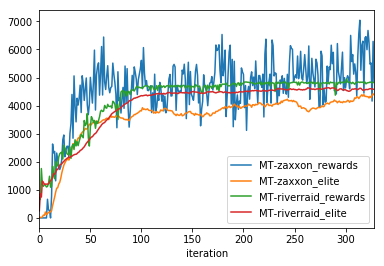

In [4]:
for exp_name, exp in experiments.items():
    exp['cfg'] = utils.get_config(exp)
    exp['rewards'] = utils.get_rewards(exp)
#    exp['plot_rewards'] = utils.plot_rewards(exp)
#    exp['plot_pareto'] = utils.plot_pareto(exp)
experiments['MT']['rewards'].plot()

In [6]:
experiments['MT']['cfg']

{'episode_cutoff_mode': 5000,
 'games': ['zaxxon', 'riverraid'],
 'iterations': 329,
 'l2coeff': 0.005,
 'learn_option': 'concat_rewards',
 'learn_options': ['concat_rewards',
  'alternate_games',
  'equal_prob_random_choice'],
 'model': 'ModelVirtualBN',
 'mutation_power': 0.02,
 'num_test_episodes': 400,
 'num_validation_episodes': 30,
 'optimizer': {'args': {'stepsize': 0.01}, 'type': 'adam'},
 'population_size': 10000,
 'population_size_comment': 'Must be divisible by 4',
 'return_proc_mode': 'centered_rank',
 'timesteps': 5000000000.0}

In [203]:
import scipy

def get_bins(min_val, max_val, bin_size):
    return [i for i in range(int(min_val), int(max_val) + bin_size, bin_size)]

def get_dkl_data(cfg, game_idx, iteration, bin_size, epsilon, min_reward=0, max_reward=10000):
    rewards = utils.get_iter_log(cfg['dir'], iteration, 'game' + str(game_idx) + '_rewards')
    rewards = np.array(list(map(lambda x: np.mean(x), rewards)))
    min_reward, max_reward = 0, 10000
    bins = get_bins(min_reward, max_reward, bin_size)
    rewards_per_bin = np.histogram(rewards, bins)[0]
    original_proportion_rewards_per_bin = rewards_per_bin / rewards.shape[0]
    epsilon_proportion_rewards_per_bin = original_proportion_rewards_per_bin + epsilon
    proportion_rewards_per_bin = epsilon_proportion_rewards_per_bin / sum(epsilon_proportion_rewards_per_bin)
    return proportion_rewards_per_bin

def compute_dkl(cfg, game_idx, iteration, bin_size, epsilon):
    offspring = get_dkl_data(cfg, game_idx, iteration, bin_size, epsilon)
    parent = get_dkl_data(cfg, game_idx, int(iteration) - 1, bin_size, epsilon)
    return scipy.stats.entropy(offspring, parent)


In [204]:
cfg = experiments['MT']
game_idx = 0
iterations = range(1, 200)
bin_size = 100
epsilon = 0.01
dkl_game_idx0 = pd.DataFrame.from_dict({
    'dkl': [compute_dkl(cfg, game_idx, i, bin_size, epsilon) for i in iterations]
})

In [205]:
cfg = experiments['MT']
game_idx = 1
iterations = range(1, 200)
bin_size = 100
epsilon = 0.01
dkl_game_idx1 = pd.DataFrame.from_dict({
    'dkl': [compute_dkl(cfg, game_idx, i, bin_size, epsilon) for i in iterations]
})

In [206]:
dkl = pd.DataFrame.from_dict({
    'dkl_game0': dkl_game_idx0.dkl,
    'dkl_game1': dkl_game_idx1.dkl
})

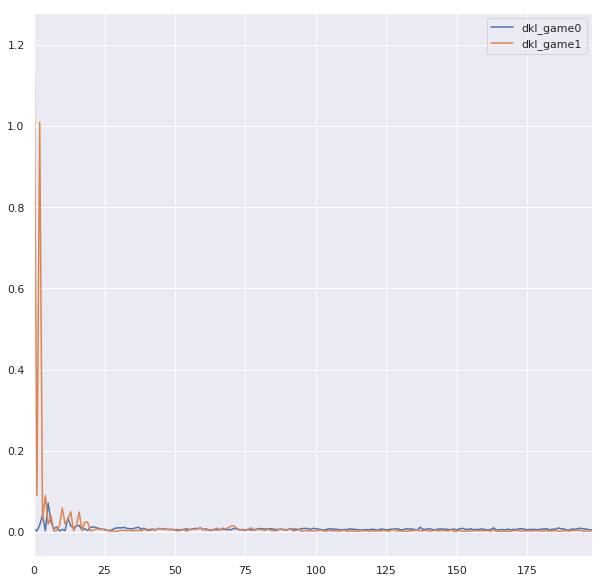

In [207]:
sns.set(rc={'figure.figsize': (10, 10)})
dkl.plot()